uncomment if executing in google colab

In [1]:
# ! pip uninstall pyro-ppl
# ! pip install pyro-ppl==1.5.1
# ! unzip fonts.zip 
# ! unzip claptchagen.zip
# ! unzip csis
# ! cp csis.py /usr/local/lib/python3.7/dist-packages/pyro/infer

In [2]:
import random
import string
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time

from torch.autograd import Variable
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from claptchagen.claptcha import Claptcha
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
# from gmade import GMADE
import matplotlib.pyplot as plt
print(pyro.__version__)

pyro.set_rng_seed(0)
torch.manual_seed(0)
np.random.seed(0)

captcha_folder = 'generated_captchas'
captchaHeight = 24
captchaWidth = 60
captchaMarginX = 0
captchaMarginY = 0
batch_size = 1

char_dict = string.digits
USE_CUDA = True
MAX_N = 4 # maximum number of letters in a captcha 
MIN_N = 2 # minimum number of letters in a captcha
MIN_NOISE = 0.01 # minimum noise
MAX_NOISE = 0.99 # maximum noise
smoke_test = False
num_steps = 400 if not smoke_test else 10
TrainingSample = 5000 if not smoke_test else 100 # number of captchas generated for training 

def randomString():
    """
    return a string with <num_char> random letters
    """
    k = random.randint(MIN_N, MAX_N) # sample number of characters
    
    rndLetters = (random.choice(char_dict) for _ in range(k))
    
    pad_spaces = MAX_N - k # pad the string so the captcha is close to center
    space = " " * (pad_spaces // 2)
    
    return space + "".join(rndLetters) + space

def ramdomNoise():
    """
    return a float between MIN_NOISE, MAX_NOISE
    """
    return random.uniform(MIN_NOISE, MAX_NOISE)

def generate_random_captcha(n, save=False):
    """
    generate n random captchas,
    return a list of texts on the captchas
    """
    # Initialize Claptcha object with random text, FreeMono as font, of size
    # 100x30px, using bicubic resampling filter and adding a bit of white noise
    c = Claptcha(randomString, "fonts/FreeSans.ttf", (captchaWidth, captchaHeight), (captchaMarginX, captchaMarginY),
             resample=Image.BILINEAR, noise=0)
    captcha_generated = [ [] for i in range(MAX_N)]
    for i in range(n):
        c.noise = ramdomNoise()
        if save:
            text, _ = c.write(os.path.join(captcha_folder, 'captcha{}.png'.format(i)))
            os.rename(os.path.join(captcha_folder, 'captcha{}.png'.format(i)),os.path.join(captcha_folder, '{}.png'.format(text + "_" + str(i))))
        text, image = c.image
        text = text.strip()
        image = np.array(image)[:, :, 0] # the generator is gray scale, only keep one channel is enough
        captcha_generated[len(text) - 1].append((text, image, c.noise))
    return captcha_generated
    
captcha_generated = generate_random_captcha(TrainingSample, save=False)
for lst in captcha_generated:
    print("number of samples in group", len(lst))
    # print some sample captcha information generated
    for i, t in enumerate(lst):
        print("text", t[0], "captcha shape", t[1].shape, "noise", t[2])
        if i >= 10:
            break

1.7.0
number of samples in group 0
number of samples in group 1700
text 82 captcha shape (24, 60) noise 0.9003077649970919
text 59 captcha shape (24, 60) noise 0.727964419299247
text 15 captcha shape (24, 60) noise 0.6501656276799302
text 41 captcha shape (24, 60) noise 0.7154826518984315
text 32 captcha shape (24, 60) noise 0.4724626182787427
text 14 captcha shape (24, 60) noise 0.03616390800734124
text 42 captcha shape (24, 60) noise 0.11314963153752981
text 93 captcha shape (24, 60) noise 0.9858799572401995
text 94 captcha shape (24, 60) noise 0.5099693123963349
text 87 captcha shape (24, 60) noise 0.4360361396113115
text 44 captcha shape (24, 60) noise 0.5935795083117388
number of samples in group 1653
text 048 captcha shape (24, 60) noise 0.8375334144945471
text 156 captcha shape (24, 60) noise 0.7886520360717119
text 185 captcha shape (24, 60) noise 0.64102177901862
text 899 captcha shape (24, 60) noise 0.08704548784132556
text 294 captcha shape (24, 60) noise 0.38599793670122656

text 82 noise 0.9003077649970919


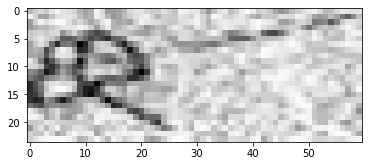

text 59 noise 0.727964419299247


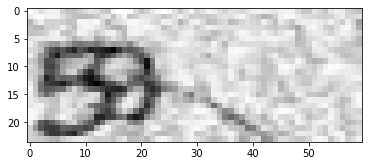

text 15 noise 0.6501656276799302


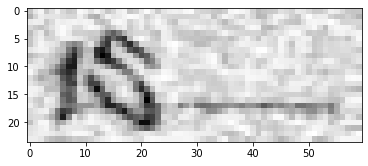

text 41 noise 0.7154826518984315


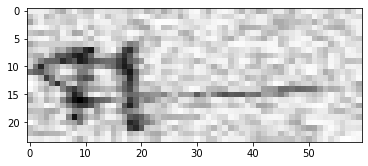

text 32 noise 0.4724626182787427


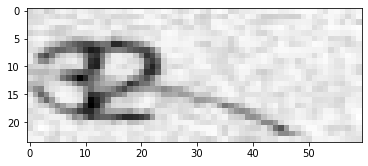

text 048 noise 0.8375334144945471


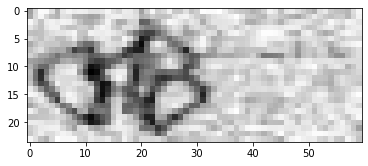

text 156 noise 0.7886520360717119


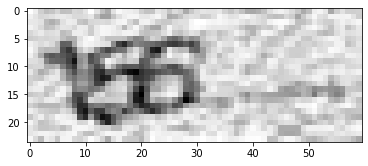

text 185 noise 0.64102177901862


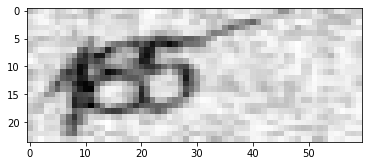

text 899 noise 0.08704548784132556


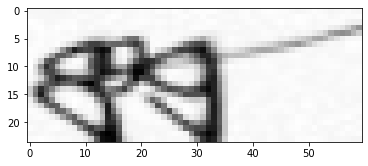

text 294 noise 0.38599793670122656


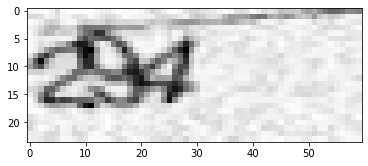

text 2129 noise 0.82354150392381


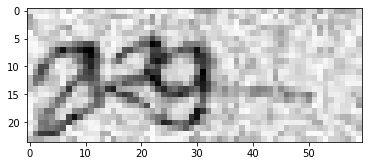

text 5422 noise 0.340207610354462


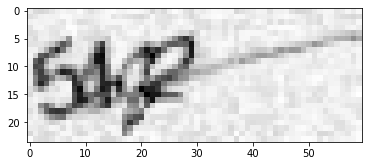

text 8961 noise 0.22890856533597448


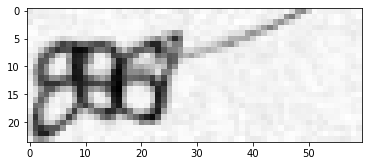

text 6024 noise 0.31343688444884715


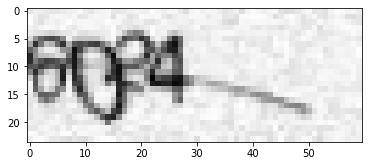

text 2181 noise 0.03507273901626142


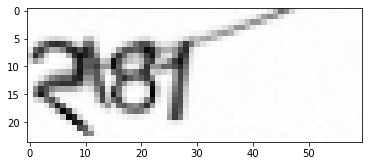

In [3]:
for lst in captcha_generated:
    for i in range(5):
        if len(lst) > 0:
            print("text", lst[i][0], "noise", lst[i][2])
            plt.imshow(255-lst[i][1], cmap="Greys")
            plt.show()
        
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# for lst in captcha_generated:
#     for i in range(5):
#         if len(lst) > 0:
#             print("text", lst[i][0], "noise", lst[i][4], "blend_alpha", lst[i][5])
#             plt.imshow(255-lst[i][1], cmap="Greys")
#             plt.show()
#             #print(255-lst[0][1])
#             plt.imshow(255-lst[i][2], cmap="Greys")
#             plt.show()
#             #print(255 - lst[0][2])
#             #plt.imshow(np.round((255-lst[0][2]) * blend_alpha + (255-lst[0][1]) * (1- blend_alpha)), cmap="Greys")
#             plt.imshow(255-lst[i][3], cmap="Greys")
#             plt.show()
#             #print(np.minimum(255, (255-lst[0][2] + 255-lst[0][1])))

In [4]:
class CaptchaDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, raw_captchas, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.raw_captchas = raw_captchas
        self.transform = transform

    def __len__(self):
        return len(self.raw_captchas)

    def __getitem__(self, idx):
        label = self.raw_captchas[idx][0]
        image = self.raw_captchas[idx][1]
        noise = self.raw_captchas[idx][2]
        
        image = np.subtract(np.divide(image, 255), 0.5)
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        return label, image, noise

In [5]:
def make_loarders(BATCH_SIZE, raw_samples):
    dataloaders = [] # dataloaders for different num of char
    for lst in raw_samples:
        if lst:
            ds = CaptchaDataset(lst)
            dataloader = DataLoader(ds, batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=0, drop_last=True)
            dataloaders.append(dataloader)
    return dataloaders

def make_batches(dataloaders):
    all_batches = []
    for dl in dataloaders:
        for i_batch, sample in enumerate(dl):
            all_batches.append(sample)
    random.shuffle(all_batches)
    random.shuffle(all_batches)
    return all_batches

TrainLoaders = make_loarders(BATCH_SIZE=batch_size, raw_samples=captcha_generated)

In [6]:
def inference(t, use_cuda=False):
    """
    one epoch of inference (iterate the training set once)
    """
    start = time.time()
    loss = 0
    length = TrainingSample
    loss_group = []
    all_batches = make_batches(TrainLoaders)
    for i_batch, sample_batched in enumerate(all_batches):
        img = sample_batched[1][0]
        #print("img", img.shape)
        if use_cuda:
            img = img.cuda()
        IMG = {"obs" : img.float()}
        imme_loss = csis.step(observations=IMG)
        loss += imme_loss / length

    print("loss at epoch {} is {}".format(t, loss), end="; ")
    print("Epoch takes", round(time.time()- start), "seconds")
    return loss

In [7]:
test_accuracies = []
test_char_accuracies = []
test_noise_differences = []
train_accuracies = []
train_char_accuracies = []
train_noise_differences = []

def _map_to_noise_range(input):
    noise_constraint = torch.distributions.constraints.interval(MIN_NOISE, MAX_NOISE)
    input = torch.distributions.transform_to(noise_constraint)(input)
    return input


def test(n = 0, use_train=False, verbose=False, use_cuda=False):
    """
    benchmarking performance on customized or training set
    """
    global test_accuracies, test_char_accuracies, train_accuracies, train_char_accuracies, train_noise_differences, test_noise_differences
    if use_train:
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=captcha_generated)
    else:
        test_captcha_generated = generate_random_captcha(n, save=False)
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=test_captcha_generated)
    
    total_correct = 0
    char_correct = 0
    total_char = 0
    all_batches = make_batches(TestLoaders)
    noise_difference = 0
    for i_batch, t in enumerate(all_batches):

        label = t[0][0]
        gt_noise = t[2][0]
        img = t[1][0]

        if use_cuda:
            img = img.cuda()
        #print("test", img.shape)
        IMG = {"obs" : img.float()}
        
        posterior = csis.run(observations=IMG)
        marginal_num = pyro.infer.EmpiricalMarginal(posterior, "num_char")
        marginal_noise = pyro.infer.EmpiricalMarginal(posterior, "noise")
        with torch.no_grad():

            N_index = marginal_num()
            N = N_index + MIN_N
            noise = _map_to_noise_range(marginal_noise())
            sampled_chars = []
            
            # sample characters one by one
            for i in range(N):
                marginal_char = pyro.infer.EmpiricalMarginal(posterior, "char_{}".format(i))()
                if use_cuda:
                    marginal_char.cpu()
                sampled_chars.append(marginal_char)
        
        chars = ""
        for i in range(len(sampled_chars)):
            c = sampled_chars[i]
            chars +=  char_dict[c]
        correct = 0
        
        for p_char, t_char in zip(chars, label):
            if p_char == t_char:
                correct += 1
        noise_difference += abs(float(noise) - float(gt_noise))
        if not verbose:
            print("N_predicted:", int(N), "| Actual N:", len(label), "| Predicted Noise:", round(float(noise), 3), "| Actual Noise:", round(float(gt_noise), 3), "| Predicted Text:", chars, "| Actual Text:", label, "| Correct:", correct)
        if correct == len(label) and int(N) == len(label):
            total_correct += 1
        char_correct += correct
        total_char += len(label)
    num_test_samples = i_batch + 1
    accuracy = total_correct / num_test_samples
    char_accuracy = char_correct / total_char
 
    
    noise_difference = noise_difference / num_test_samples
    if use_train:
        train_accuracies.append(accuracy)
        train_char_accuracies.append(char_accuracy)
        train_noise_differences.append(noise_difference)
    elif n > 10:
        test_accuracies.append(accuracy)
        test_char_accuracies.append(char_accuracy)
        test_noise_differences.append(noise_difference)
    print("use_train =", use_train, "AVG Noise Difference:", noise_difference, "Total correct:", total_correct, "accuracy:{}/{}=".format(total_correct, num_test_samples), accuracy, "char_accuracy:{}/{}=".format(char_correct, total_char), char_accuracy)

In [8]:

losses  = []
def test_cycle(use_cuda):
    
    # disable dropout
#     captchaModel.numNet.eval()
#     captchaModel.charNetSingle.eval()
    test(use_train=True, verbose=True, use_cuda=use_cuda)
    test(1000, use_train=False, verbose=True, use_cuda=use_cuda)
    #test(10, use_train=True, verbose=False, use_cuda=use_cuda)
    test(10, use_train=False, verbose=False, use_cuda=use_cuda)
    # enable dropout
#     captchaModel.numNet.train()
#     captchaModel.charNetSingle.train()

def optimize(start_epoch=1, use_cuda=False):
    """
    Training/Inferencing Stage
    """
    loss_sequence = []
    pause = 5
    save_pause = 10
    print("Optimizing...")
    for t in range(start_epoch, num_steps + 1):
        L = inference(t, use_cuda)
        loss_sequence.append(L)
        losses.append(L)
        if (t % pause == 0) and (t > 0):
            test_cycle(use_cuda=use_cuda)
        #if (t % save_pause == 0) and (t > 0):
        #    save_and_download_checkpoints("branches-1-no-var-no-tanh_model.pt", "branches-1-no-var-no-tanh_optim.pt", "branches-1-no-var-no-tanh_param_store.pt")
    plt.plot(loss_sequence)
    plt.title("loss")
    plt.show()

In [9]:
# saves the model and optimizer states to disk
def save_checkpoint(currentModel, currentOptimzier, save_model, save_opt, save_param_store):
    print("saving model to %s..." % save_model)
    torch.save(currentModel.state_dict(), save_model)
    print("saving optimizer states to %s..." % save_opt)
    currentOptimzier.save(save_opt)
    print("saving pyro pram store states to %s..." % save_param_store)
    pyro.get_param_store().save(save_param_store)
    print("done saving checkpoints to disk.")

# loads the model and optimizer states from disk
def load_checkpoint(myModel, myOptimzer, load_model, load_opt, load_param_store):
    pyro.clear_param_store()
    print("loading model from %s..." % load_model)
    myModel.load_state_dict(torch.load(load_model))
    print("loading optimizer states from %s..." % load_opt)
    myOptimzer.load(load_opt)
    print("loading pyro pram store states from %s..." % load_param_store)
    pyro.get_param_store().load(load_param_store)
    print("done loading states.")
    pyro.module("guide", myModel, update_module_params=True)

def save_and_download_checkpoints(save_model, save_opt, save_param_store):
    save_checkpoint(captchaModel, optimiser, save_model, save_opt, save_param_store)
def save_metric_to_disk(file_path):
    import json
    save_dict = {
        "test_accuracies" : test_accuracies,
        "test_char_accuracies" : test_char_accuracies,
        "test_noise_differences" : test_noise_differences,
        "train_accuracies"  : train_accuracies,
        "train_char_accuracies"  : train_char_accuracies,
        "train_noise_differences" : train_noise_differences,
    }
    print(save_dict)
    with open(file_path, 'w') as fout:
        json.dump(save_dict, fout)

In [10]:
import guide_mean_field_v2 as guide
import model

In [11]:
class ObsEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, img):
        #print(img.shape)
        img = img.unsqueeze(0).unsqueeze(0).float()

        img = self.pool(F.relu(self.conv1(img)))
        #print(img.shape)
        img = self.pool(F.relu(self.conv2(img)))
        #print(img.shape)

        img = self.pool(F.relu(self.conv3(img)))
        #print(img.shape)
        
        return img
obs_embedding = ObsEmbedding().cuda()

In [12]:
def wrapped_guide(observations):
    pyro.module("obs_embedding", obs_embedding)
    emb_obs = obs_embedding(observations['obs'])
    return guide.model({'obs':emb_obs})
    

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n0 = count_parameters(obs_embedding)
n1 = count_parameters(guide._nn_model_char_char_i)
n2 = count_parameters(guide._nn_model_noise)
n3 = count_parameters(guide._nn_model_num_char)
print(n0, n1, n2, n3, "total:", n0+n1+n2+n3)

222080 3075803 2212802 2214003 total: 7724688


In [14]:
optimiser = pyro.optim.Adam({'lr': 2e-4})
csis = pyro.infer.CSIS(model.model, wrapped_guide, optimiser, num_inference_samples=1)

optimize(1, USE_CUDA)
# test_cycle(USE_CUDA)
save_metric_to_disk("captcha_guide3.json")


Optimizing...


C:\Users\frank\anaconda3\envs\pyro-env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\captcha\guide_mean_field_v2.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  num_char = P.sample('num_char', PD.Categorical(TN.LogSoftmax()(T.reshape(
C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\captcha\guide_mean_field_v2.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  char_i = P.sample(f'char_{i}', PD.Categorical(TN.LogSoft

loss at epoch 1 is 6.073315059848172; Epoch takes 2059 seconds
loss at epoch 2 is 4.576766443235539; Epoch takes 2244 seconds
loss at epoch 3 is 3.8556234765225246; Epoch takes 2246 seconds
loss at epoch 4 is 3.400553190065809; Epoch takes 2241 seconds
loss at epoch 5 is 3.076870967582807; Epoch takes 2238 seconds
use_train = True AVG Noise Difference: 0.04501916865267485 Total correct: 337 accuracy:337/5000= 0.0674 char_accuracy:4412/14947= 0.2951762895564327
use_train = False AVG Noise Difference: 0.0454307100258766 Total correct: 66 accuracy:66/1000= 0.066 char_accuracy:893/3002= 0.2974683544303797
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.764 | Actual Noise: 0.759 | Predicted Text: 949 | Actual Text: 201 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.666 | Actual Noise: 0.684 | Predicted Text: 1000 | Actual Text: 0410 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.251 | Actual Noise: 0.086 | Predicted Text: 77 | Actual Text: 73 | Correct: 1
N

loss at epoch 22 is 1.9348883926933473; Epoch takes 1868 seconds
loss at epoch 23 is 1.924756575322074; Epoch takes 1921 seconds
loss at epoch 24 is 1.9014400482536005; Epoch takes 1992 seconds
loss at epoch 25 is 1.8995174944513487; Epoch takes 2109 seconds
use_train = True AVG Noise Difference: 0.031556407403803374 Total correct: 531 accuracy:531/5000= 0.1062 char_accuracy:5405/14947= 0.361611025623871
use_train = False AVG Noise Difference: 0.03245284090120693 Total correct: 102 accuracy:102/1000= 0.102 char_accuracy:1060/2976= 0.35618279569892475
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.506 | Actual Noise: 0.509 | Predicted Text: 110 | Actual Text: 407 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.657 | Actual Noise: 0.634 | Predicted Text: 2271 | Actual Text: 1872 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.193 | Actual Noise: 0.141 | Predicted Text: 99 | Actual Text: 98 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.298

loss at epoch 42 is 1.7459352471606868; Epoch takes 1863 seconds
loss at epoch 43 is 1.7352352894459524; Epoch takes 1856 seconds
loss at epoch 44 is 1.745513846160001; Epoch takes 1863 seconds
loss at epoch 45 is 1.7355695008279441; Epoch takes 1865 seconds
use_train = True AVG Noise Difference: 0.03320305708656527 Total correct: 568 accuracy:568/5000= 0.1136 char_accuracy:5506/14947= 0.3683682344283134
use_train = False AVG Noise Difference: 0.034124896355684636 Total correct: 121 accuracy:121/1000= 0.121 char_accuracy:1091/2997= 0.3640306973640307
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.427 | Actual Noise: 0.416 | Predicted Text: 999 | Actual Text: 599 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.679 | Actual Noise: 0.654 | Predicted Text: 70 | Actual Text: 70 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.18 | Actual Noise: 0.086 | Predicted Text: 556 | Actual Text: 516 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.336 | 

loss at epoch 62 is 1.6587585349921163; Epoch takes 1866 seconds
loss at epoch 63 is 1.6761865666982647; Epoch takes 1875 seconds
loss at epoch 64 is 1.6417328621011227; Epoch takes 1870 seconds
loss at epoch 65 is 1.6404044274416207; Epoch takes 1868 seconds
use_train = True AVG Noise Difference: 0.02681911684272085 Total correct: 630 accuracy:630/5000= 0.126 char_accuracy:5591/14947= 0.37405499431324013
use_train = False AVG Noise Difference: 0.026336325215367398 Total correct: 106 accuracy:106/1000= 0.106 char_accuracy:1111/3047= 0.36462093862815886
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.794 | Actual Noise: 0.792 | Predicted Text: 95 | Actual Text: 20 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.44 | Actual Noise: 0.439 | Predicted Text: 0404 | Actual Text: 0460 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.515 | Actual Noise: 0.503 | Predicted Text: 81 | Actual Text: 81 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.39 |

loss at epoch 83 is 1.5968183556687348; Epoch takes 1956 seconds
loss at epoch 84 is 1.6019877429021172; Epoch takes 1935 seconds
loss at epoch 85 is 1.610811780367196; Epoch takes 1932 seconds
use_train = True AVG Noise Difference: 0.02385565913240023 Total correct: 613 accuracy:613/5000= 0.1226 char_accuracy:5581/14947= 0.3733859637385428
use_train = False AVG Noise Difference: 0.024035762414308888 Total correct: 110 accuracy:110/1000= 0.11 char_accuracy:1079/3002= 0.35942704863424385
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.882 | Actual Noise: 0.894 | Predicted Text: 312 | Actual Text: 123 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.403 | Actual Noise: 0.405 | Predicted Text: 211 | Actual Text: 217 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.15 | Actual Noise: 0.079 | Predicted Text: 1211 | Actual Text: 2047 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.228 | Actual Noise: 0.198 | Predicted Text: 445 | Actual Text: 544 

loss at epoch 104 is 1.5730072183292672; Epoch takes 1928 seconds
loss at epoch 105 is 1.5699854395696988; Epoch takes 1910 seconds
use_train = True AVG Noise Difference: 0.025071477493651947 Total correct: 602 accuracy:602/5000= 0.1204 char_accuracy:5549/14947= 0.3712450658995116
use_train = False AVG Noise Difference: 0.0242327099673606 Total correct: 114 accuracy:114/1000= 0.114 char_accuracy:1122/2973= 0.3773965691220989
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.894 | Actual Noise: 0.922 | Predicted Text: 2282 | Actual Text: 6828 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.676 | Actual Noise: 0.66 | Predicted Text: 9990 | Actual Text: 0992 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.592 | Actual Noise: 0.579 | Predicted Text: 75 | Actual Text: 57 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.916 | Actual Noise: 0.987 | Predicted Text: 0505 | Actual Text: 6056 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 

loss at epoch 124 is 1.5285069005602308; Epoch takes 1882 seconds
loss at epoch 125 is 1.5274961891980632; Epoch takes 1909 seconds
use_train = True AVG Noise Difference: 0.024016438310496328 Total correct: 631 accuracy:631/5000= 0.1262 char_accuracy:5625/14947= 0.3763296982672108
use_train = False AVG Noise Difference: 0.023184793206175686 Total correct: 123 accuracy:123/1000= 0.123 char_accuracy:1110/2989= 0.37136165941786553
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.778 | Actual Noise: 0.805 | Predicted Text: 11 | Actual Text: 18 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.523 | Actual Noise: 0.501 | Predicted Text: 229 | Actual Text: 924 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.15 | Actual Noise: 0.045 | Predicted Text: 11 | Actual Text: 91 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.447 | Actual Noise: 0.446 | Predicted Text: 99 | Actual Text: 89 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.607 |

loss at epoch 144 is 1.5307962530570045; Epoch takes 1867 seconds
loss at epoch 145 is 1.5342406769426704; Epoch takes 1906 seconds
use_train = True AVG Noise Difference: 0.021033019254359527 Total correct: 647 accuracy:647/5000= 0.1294 char_accuracy:5771/14947= 0.38609754465779084
use_train = False AVG Noise Difference: 0.02072972517762108 Total correct: 123 accuracy:123/1000= 0.123 char_accuracy:1180/3034= 0.3889255108767304
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.268 | Actual Noise: 0.238 | Predicted Text: 8566 | Actual Text: 3862 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.402 | Actual Noise: 0.403 | Predicted Text: 101 | Actual Text: 910 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.09 | Actual Noise: 0.031 | Predicted Text: 3522 | Actual Text: 9520 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.597 | Actual Noise: 0.568 | Predicted Text: 00 | Actual Text: 60 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 

loss at epoch 164 is 1.527214165022424; Epoch takes 1862 seconds
loss at epoch 165 is 1.5053601656700442; Epoch takes 1885 seconds
use_train = True AVG Noise Difference: 0.023496212302139788 Total correct: 608 accuracy:608/5000= 0.1216 char_accuracy:5597/14947= 0.37445641265805846
use_train = False AVG Noise Difference: 0.021757929739173027 Total correct: 113 accuracy:113/1000= 0.113 char_accuracy:1093/3021= 0.36180072823568354
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.388 | Actual Noise: 0.4 | Predicted Text: 1266 | Actual Text: 1266 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.167 | Actual Noise: 0.081 | Predicted Text: 558 | Actual Text: 585 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.392 | Actual Noise: 0.387 | Predicted Text: 03 | Actual Text: 30 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.167 | Actual Noise: 0.114 | Predicted Text: 11 | Actual Text: 31 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.72

loss at epoch 184 is 1.4919421011630296; Epoch takes 1866 seconds


KeyboardInterrupt: 

# 